In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta
from timeit import default_timer
# import seaborn as sns
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14
})


In [2]:
dummy = xr.open_mfdataset("/pscratch/sd/a/amahesh/hens/demo_bred_1step/ensemble_out_0000*_2020-06-18-00-00-00.nc",
                     group='global', concat_dim='ensemble', combine='nested')

/opt/miniconda3/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
def load_hens_exceed_observed(curr_date, curr_date_idx):
    stats_ds = xr.open_dataset(f"/pscratch/sd/a/amahesh/hens_h5/stats/t2m_{curr_date:%Y%m%d}_reduced-lead-04-07-10.h5")
    stats_ds = stats_ds.rename({"phony_dim_2" : 'lat',
                     "phony_dim_3" : 'lon',
                     'phony_dim_1' : 'lead_time'})
    stats_ds['lat'] = dummy['lat']
    stats_ds['lon'] = dummy['lon']
    # Select 10 day lead time
    return stats_ds['t2m_exceed_observed'].isel(phony_dim_0=curr_date_idx, lead_time=[8,9,10,11]).values

def load_era5(curr_date):
    valid_date = curr_date + timedelta(days=10)
    print(valid_date)
    true = xr.open_dataset("/pscratch/sd/p/pharring/74var-6hourly/staging/2023.h5", mode='r')
    true = true.rename({'phony_dim_0' : 'time',
                        'phony_dim_2' : 'lat', 
                 'phony_dim_3' : 'lon',
                 'phony_dim_1' : 'channel'})
    true['lat'] = dummy['lat']
    true['lon'] = dummy['lon']
    true['channel'] = ["u10m", "v10m", "u100m", "v100m", "t2m", "sp", "msl", "tcwv", "2d", "u50", "u100", "u150", "u200", "u250", "u300", "u400", "u500", "u600", "u700", "u850", "u925", "u1000", "v50", "v100", "v150", "v200", "v250", "v300", "v400", "v500", "v600", "v700", "v850", "v925", "v1000", "z50", "z100", "z150", "z200", "z250", "z300", "z400", "z500", "z600", "z700", "z850", "z925", "z1000", "t50", "t100", "t150", "t200", "t250", "t300", "t400", "t500", "t600", "t700", "t850", "t925", "t1000", "q50", "q100", "q150", "q200", "q250", "q300", "q400", "q500", "q600", "q700", "q850", "q925", "q1000"]
    true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')

    true = true.sel(time=f"{valid_date:%Y-%m-%d}")
    true_t2m = true['fields'].sel(channel='t2m')
    return true_t2m.values

def load_mu_sigma(curr_date):
    valid_date = curr_date + timedelta(days=10)
    print(valid_date)
    mu, sigma = [],[]
    for hour in [0,6,12,18]:
        mu.append(xr.open_zarr(f"/pscratch/sd/a/amahesh/hens/thresholds/t2m_mean_{valid_date.month:02d}_{hour:02d}/").rename({'VAR_2T' : 't2m',
                        'latitude' : 'lat', 
                        'longitude' : 'lon'}))
        sigma.append(xr.open_zarr(f"/pscratch/sd/a/amahesh/hens/thresholds/t2m_std_{valid_date.month:02d}_{hour:02d}/").rename({'VAR_2T' : 't2m',
                        'latitude' : 'lat', 
                        'longitude' : 'lon'}))
    mu = xr.concat(mu, dim='lead_time')
    sigma = xr.concat(sigma, dim='lead_time')
    return mu['t2m'].values, sigma['t2m'].values

In [11]:
dates = pd.date_range('2023-06-01', '2023-08-31', freq='D')
all_zscores, all_num_ensemble_members = [], []
for idx, curr_date in enumerate(dates):
    start = default_timer()
    hens_eo = load_hens_exceed_observed(curr_date, idx)
    era5 = load_era5(curr_date)
    
    mu, sigma = load_mu_sigma(curr_date)
    
    era5_zscore = (era5 - mu)/sigma
    z_scores = era5_zscore
    # num_ensemble_members = xr.where(era5_zscore > 0, hens_eo, np.nan)
    all_zscores.append(z_scores)
    all_num_ensemble_members.append(hens_eo)
    
   
   


2023-06-11 00:00:00
2023-06-11 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-12 00:00:00
2023-06-12 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-13 00:00:00
2023-06-13 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-14 00:00:00
2023-06-14 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-15 00:00:00
2023-06-15 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-16 00:00:00
2023-06-16 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-17 00:00:00
2023-06-17 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-18 00:00:00
2023-06-18 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-19 00:00:00
2023-06-19 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-20 00:00:00
2023-06-20 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-21 00:00:00
2023-06-21 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-22 00:00:00
2023-06-22 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-23 00:00:00
2023-06-23 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-24 00:00:00
2023-06-24 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-25 00:00:00
2023-06-25 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-26 00:00:00
2023-06-26 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-27 00:00:00
2023-06-27 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-28 00:00:00
2023-06-28 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-29 00:00:00
2023-06-29 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-06-30 00:00:00
2023-06-30 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-01 00:00:00
2023-07-01 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-02 00:00:00
2023-07-02 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-03 00:00:00
2023-07-03 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-04 00:00:00
2023-07-04 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-05 00:00:00
2023-07-05 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-06 00:00:00
2023-07-06 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-07 00:00:00
2023-07-07 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-08 00:00:00
2023-07-08 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-09 00:00:00
2023-07-09 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-10 00:00:00
2023-07-10 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-11 00:00:00
2023-07-11 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-12 00:00:00
2023-07-12 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-13 00:00:00
2023-07-13 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-14 00:00:00
2023-07-14 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-15 00:00:00
2023-07-15 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-16 00:00:00
2023-07-16 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-17 00:00:00
2023-07-17 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-18 00:00:00
2023-07-18 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-19 00:00:00
2023-07-19 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-20 00:00:00
2023-07-20 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-21 00:00:00
2023-07-21 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-22 00:00:00
2023-07-22 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-23 00:00:00
2023-07-23 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-24 00:00:00
2023-07-24 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-25 00:00:00
2023-07-25 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-26 00:00:00
2023-07-26 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-27 00:00:00
2023-07-27 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-28 00:00:00
2023-07-28 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-29 00:00:00
2023-07-29 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-30 00:00:00
2023-07-30 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-07-31 00:00:00
2023-07-31 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-01 00:00:00
2023-08-01 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-02 00:00:00
2023-08-02 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-03 00:00:00
2023-08-03 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-04 00:00:00
2023-08-04 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-05 00:00:00
2023-08-05 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-06 00:00:00
2023-08-06 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-07 00:00:00
2023-08-07 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-08 00:00:00
2023-08-08 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-09 00:00:00
2023-08-09 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-10 00:00:00
2023-08-10 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-11 00:00:00
2023-08-11 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-12 00:00:00
2023-08-12 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-13 00:00:00
2023-08-13 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-14 00:00:00
2023-08-14 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-15 00:00:00
2023-08-15 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-16 00:00:00
2023-08-16 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-17 00:00:00
2023-08-17 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-18 00:00:00
2023-08-18 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-19 00:00:00
2023-08-19 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-20 00:00:00
2023-08-20 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-21 00:00:00
2023-08-21 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-22 00:00:00
2023-08-22 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-23 00:00:00
2023-08-23 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-24 00:00:00
2023-08-24 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-25 00:00:00
2023-08-25 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-26 00:00:00
2023-08-26 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-27 00:00:00
2023-08-27 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-28 00:00:00
2023-08-28 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-29 00:00:00
2023-08-29 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-30 00:00:00
2023-08-30 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-08-31 00:00:00
2023-08-31 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-09-01 00:00:00
2023-09-01 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-09-02 00:00:00
2023-09-02 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-09-03 00:00:00
2023-09-03 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-09-04 00:00:00
2023-09-04 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-09-05 00:00:00
2023-09-05 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-09-06 00:00:00
2023-09-06 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-09-07 00:00:00
2023-09-07 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-09-08 00:00:00
2023-09-08 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-09-09 00:00:00
2023-09-09 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


2023-09-10 00:00:00
2023-09-10 00:00:00


/tmp/ipykernel_305798/1472608426.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  true['time'] = pd.date_range("2023-01-01", periods=1460, freq='6H')


In [12]:
all_zscores_np = np.stack(all_zscores, axis=0)
all_num_ensemble_members_np = np.stack(all_num_ensemble_members, axis=0)

In [13]:
np.save("/pscratch/sd/a/amahesh/temp/all_zscores_np.npy", all_zscores_np)
np.save("/pscratch/sd/a/amahesh/temp/all_num_ensemble_members_np_incneg.npy", all_num_ensemble_members_np)

In [3]:
all_zscores_np = np.load("/pscratch/sd/a/amahesh/temp/all_zscores_np.npy")
all_num_ensemble_members_np = np.load("/pscratch/sd/a/amahesh/temp/all_num_ensemble_members_np_incneg.npy")

<Figure size 1000x600 with 0 Axes>

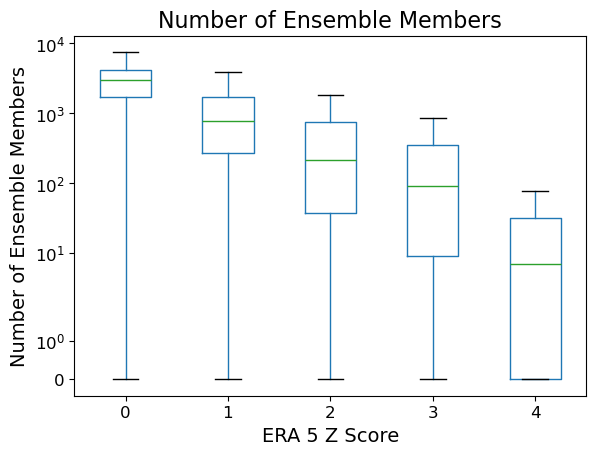

In [14]:
# Create a DataFrame
data = pd.DataFrame({'Z Score': all_zscores_np[10].flatten(), 'Number of Ensemble Members': all_num_ensemble_members_np[10].flatten()})

# Convert Z scores to integers
data['Z Score Integer'] = pd.cut(data['Z Score'], bins=np.arange(0, 6), labels=np.arange(0, 5))
    

plt.figure(figsize=(10, 6))
data.boxplot(column='Number of Ensemble Members', by='Z Score Integer', grid=False, showfliers=False)
# plt.title('Boxplot of Number of Ensemble Members by Z Score')
plt.xlabel('ERA 5 Z Score')
plt.ylabel('Number of Ensemble Members')
plt.suptitle('')  # Remove default title
plt.yscale('symlog')
plt.show()